In [1]:
"""
Update Parameters Here
"""
COLLECTION_NAME = "MekaVerse"
CONTRACT = "0x9a534628b4062e123ce7ee2222ec20b86e16ca8f"
LAST_N_EVENTS = 150

GRIFTER_ADDRESS = ""  # optional overlay of grifter sales on map (grifter sales must have occured in last 'LAST_N_EVENTS' sales)

In [2]:
"""
@author: mdigi14
"""

import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from utils import config

ETHER_UNITS = 1e18
RARITY_DB = pd.read_csv(f"{config.RARITY_FOLDER}/{COLLECTION_NAME}_raritytools.csv")


events = []
sales = []
url = "https://api.opensea.io/api/v1/events"
offset = 0

"""
Plot params
"""
plt.rcParams.update({"figure.facecolor": "white", "savefig.facecolor": "white"})

"""
Helper Functions
"""


def getOpenseaEvents(contract, offset):
    print(offset)
    querystring = {
        "event_type": "successful",
        "only_opensea": "false",
        "offset": offset,
        "limit": "200",
        "asset_contract_address": contract,
    }

    headers = {"Accept": "application/json", "X-API-KEY": config.OPENSEA_API_KEY}

    response = requests.request("GET", url, headers=headers, params=querystring)
    resJson = response.json()
    return resJson

0


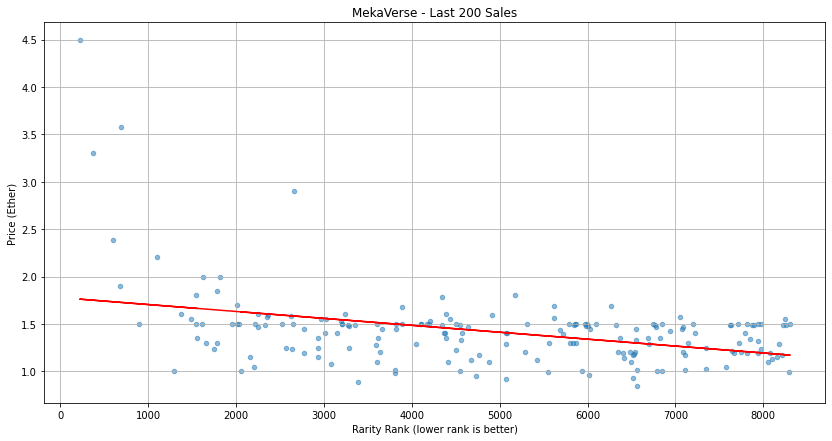

In [3]:
"""
Generate Plot
"""

while offset < LAST_N_EVENTS:
    data = getOpenseaEvents(CONTRACT, offset)
    events.extend(data["asset_events"])
    offset += 200


for event in events:
    try:
        tokenId = int(event["asset"]["token_id"])
        sale = dict()
        sale["TOKEN_ID"] = tokenId
        sale["USER"] = event["transaction"]["from_account"]["address"]
        sale["SELLER"] = event["seller"]["address"]

        sale["DATE"] = event["created_date"]
        sale["RANK"] = int(RARITY_DB[RARITY_DB["TOKEN_ID"] == tokenId]["Rank"])
        sale["PRICE"] = float(event["total_price"]) / ETHER_UNITS

    except:
        continue

    sales.append(sale)


df = pd.DataFrame(sales)
df = df[df["RANK"].notna()]
df.to_csv("recent_sales.csv")

X = df["RANK"].values.reshape(-1, 1)
Y = df["PRICE"].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

df = df.sort_values(by="RANK")
ax = df.plot.scatter(
    x="RANK",
    y="PRICE",
    grid=True,
    alpha=0.5,
    title="{}".format(COLLECTION_NAME),
    figsize=(14, 7),
)

if GRIFTER_ADDRESS != "":
    GRIFTER_DB = df[df["SELLER"] == GRIFTER_ADDRESS]
    ranks = GRIFTER_DB["RANK"]
    prices = GRIFTER_DB["PRICE"]
    plt.scatter(x=ranks, y=prices, color="black", s=25, figsize=(14, 7))

plt.plot(X, Y_pred, color="red")
plt.xlabel("Rarity Rank (lower rank is better)")
plt.ylabel("Price (Ether)")
plt.title("{} - Last 200 Sales".format(COLLECTION_NAME))
plt.savefig("figures/{}_price_vs_rank.png".format(COLLECTION_NAME))
plt.show()